# Image Caption Generation - Team 399

Required libraries

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

In [234]:
!pip install tensorflow
!pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [232]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [196]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Accessing dataset from kaggle

In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [7]:
!kaggle datasets download adityajn105/flickr8k

100% 1.04G/1.04G [00:48<00:00, 19.8MB/s]
100% 1.04G/1.04G [00:48<00:00, 22.9MB/s]


In [8]:
!unzip '/content/flickr8k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### 2. Paths of captions and images

In [31]:
text_path = "/content/captions.txt"
image_path = "/content/Images/"

In [32]:
images = os.listdir(image_path)
print("The number of image flies in Dataset: {}".format(len(images)))

The number of image flies in Dataset: 8091


In [33]:
captions = open(text_path,'r')
text = captions.read()
captions.close()

### 3. Exploring through the data

- Images

Random array images index:  [2704 4241 5985 6842  413]

Image Name: 2345984157_724823b1e4.jpg



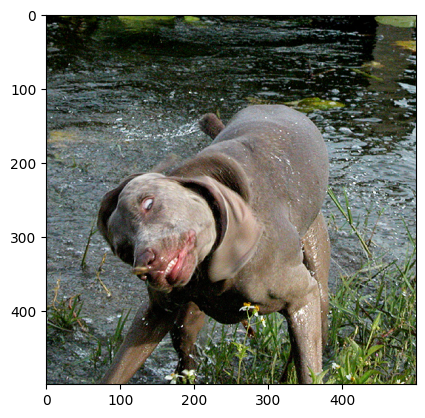


Image Name: 3157622277_9f59b4f62f.jpg



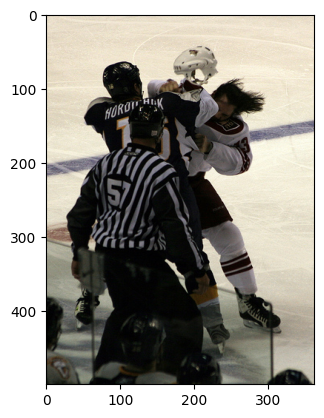


Image Name: 1662261486_db967930de.jpg



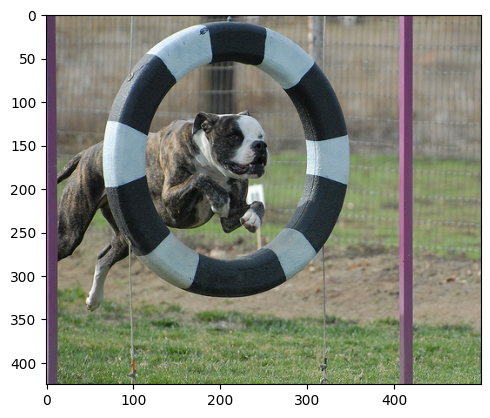


Image Name: 3520617304_e53d37f0af.jpg



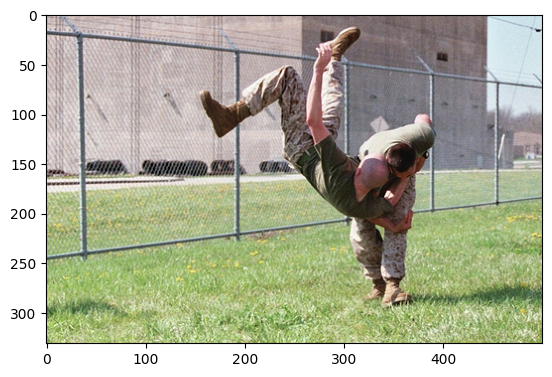


Image Name: 3485816074_363cab4bff.jpg



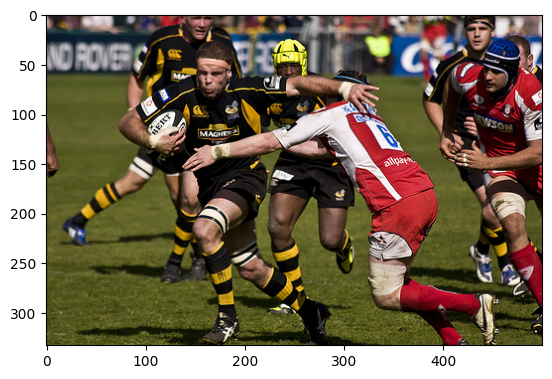

In [37]:
# example images in the dataset

import cv2
import matplotlib.pyplot as plt
import numpy as np

random_array = np.random.randint(low=0, high=len(images), size=5)
print("Random array images index: ",random_array)

for i in random_array:
    plt.figure()

    # Print the image path for debugging
    print(f"\nImage Name: {images[i]}\n")

    img = cv2.imread(image_path+images[i])

    # Check if the image read was successful
    if img is None:
        print(f"Failed to read image: {images[i]}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


- Captions (text) - Bar plot of the top 30 most repeated words

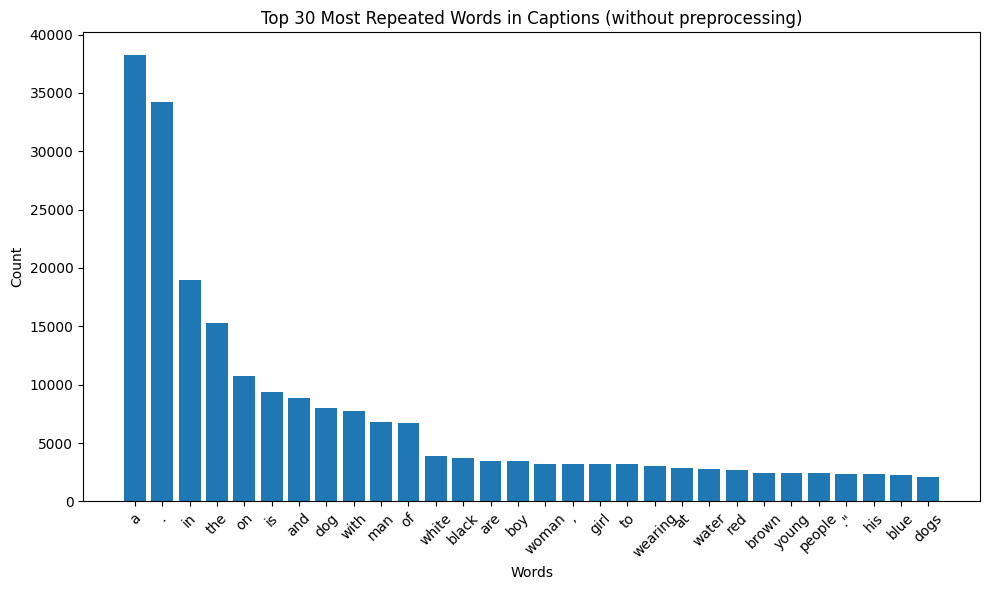

In [44]:
import matplotlib.pyplot as plt
from collections import Counter

# Read the text file of captions
with open('captions.txt', 'r') as file:
    captions = file.read().splitlines()

# Concatenate all captions into a single string
all_captions = ' '.join(captions)

# Split the text into individual words
words = all_captions.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get the top 15 most common words and their counts
top_words = word_counts.most_common(30)
top_words = dict(top_words)

# Prepare the data for the graph
word_labels = list(top_words.keys())
word_values = list(top_words.values())

# Create a bar plot of the top 30 most repeated words
plt.figure(figsize=(10, 6))
plt.bar(word_labels, word_values)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 30 Most Repeated Words in Captions (without preprocessing)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. Creating dictonary for image to its captions

In [126]:
# Initialize an empty dictionary to store image IDs and captions
image_caption_mapping = {}

# Iterate over each line in the input text
for line in tqdm(text.split("\n")):
    # Split the line by comma (,) to extract tokens
    tokens = line.split(",")

    # Skip the line if it doesn't contain the necessary information
    if len(tokens) < 2:
        continue

    # Extract the image ID from the first token and the captions from the remaining tokens
    image_id, captions = tokens[0], tokens[1:]

    # Remove the file extension from the image ID
    image_id = image_id.split(".")[0]

    # Join the caption tokens into a single string
    caption = " ".join(captions)

    # Create an empty list if the image ID is not already present in the dictionary
    if image_id not in image_caption_mapping:
        image_caption_mapping[image_id] = []

    # Append the caption to the list of captions for the image ID
    image_caption_mapping[image_id].append(caption)

100%|██████████| 40457/40457 [00:00<00:00, 420603.10it/s]


In [127]:
del image_caption_mapping['image'] # unwanted column name value in the data

In [128]:
len(image_caption_mapping) # total captions

8091

In [111]:
# Iterate over the first ten items in the dictionary
for image_id, captions in list(image_caption_mapping.items())[:10]:
    print(f"Image ID: {image_id}")
    print("Captions:")
    for caption in captions:
        print(caption)
    print("---------------------")

Image ID: 1000268201_693b08cb0e
Captions:
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
---------------------
Image ID: 1001773457_577c3a7d70
Captions:
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
---------------------
Image ID: 1002674143_1b742ab4b8
Captions:
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rain

- printing images along with captions

[4784 4519 4359  694 2440]


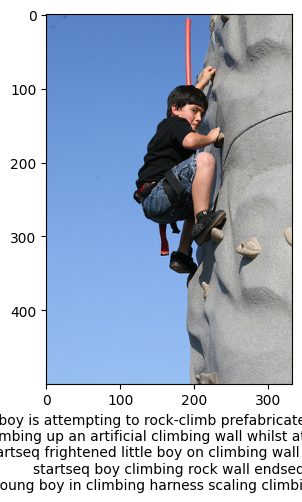

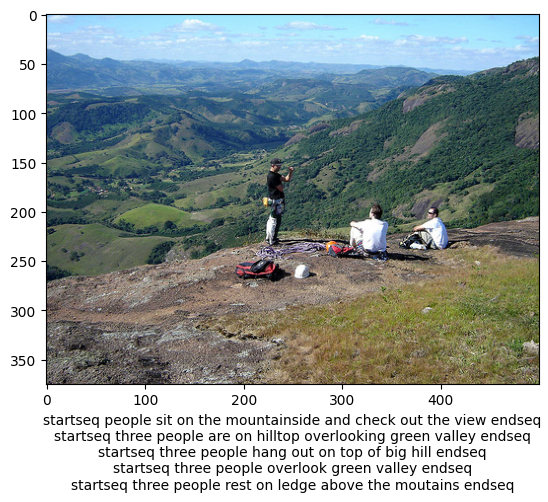

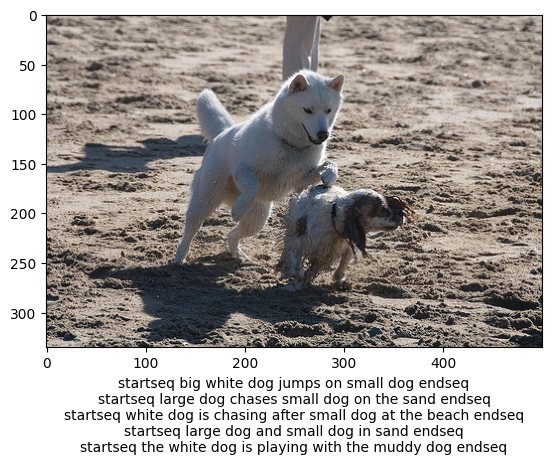

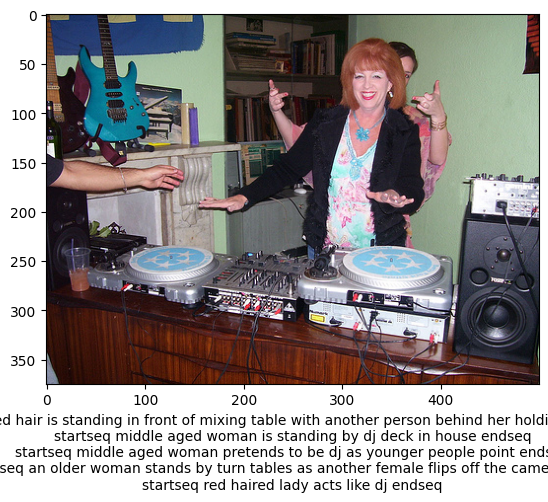

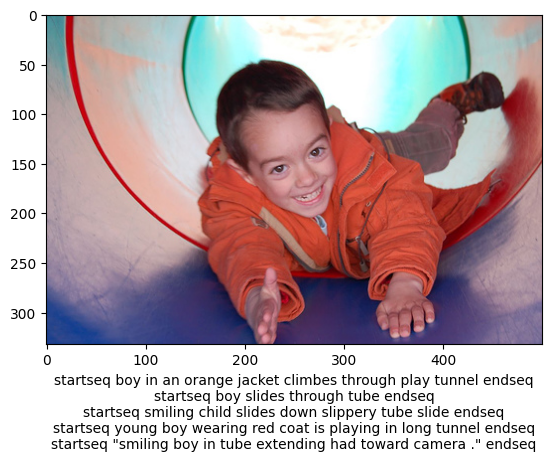

In [200]:
import matplotlib.pyplot as plt
import numpy as np

random_array = np.random.randint(low=0, high=len(images), size=5)
print(random_array)

for i in random_array:
    plt.figure()
    img_name = images[i]
    img = cv2.imread(image_path+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Concatenate all the captions into a single string
    all_captions = "\n".join(image_caption_mapping[img_name.split('.')[-2]])

    # Set the concatenated captions as the xlabel of the image
    plt.xlabel(all_captions)

    plt.imshow(img)
    plt.show()

### 5. Extracting all the captions seperately in a list

In [129]:
all_captions = []

In [130]:
all_captions = []
for key in image_caption_mapping:
  for caption in image_caption_mapping[key]:
    all_captions.append(caption)
len(all_captions)
all_captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [131]:
len(all_captions)

40455

In [87]:
all_captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

- wordcloud of captions

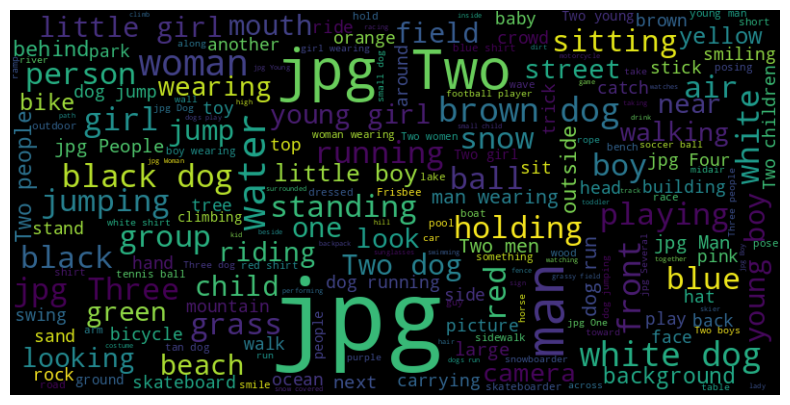

In [90]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the text file
with open(text_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 6. Pre-processing the images and captions

Images Pre-processing
- Creating model to extract features from images (Images Feature Extraction)
- Removing the last layer (softmax layer) as making the model as a feature Extractor

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [52]:
# Load the VGG16 model
vgg16_model = VGG16()

# Create a new model by removing the last layer of the VGG16 model
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)

# Display the summary of the modified VGG16 model
vgg16_model.summary()

553467096/553467096 [==============================] - 27s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

- Extracting features from the images

In [54]:
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

In [55]:
BASE_DIR = '/content/'

# Create a dictionary to store the extracted features
features = {}

# Set the directory path to the images
directory = os.path.join(BASE_DIR, 'Images')

# Iterate over each image in the directory
for img_name in tqdm(os.listdir(directory)):
    # Load the image from the file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))

    # Convert the image pixels to a numpy array
    image = img_to_array(image)

    # Reshape the image data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess the image
    image = preprocess_input(image)

    # Extract features using the modified VGG16 model
    feature = vgg16_model.predict(image, verbose=8)

    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]

    # Store the extracted features in the dictionary
    features[image_id] = feature


100%|██████████| 8091/8091 [10:28<00:00, 12.86it/s]


In [58]:
len(features)

8091

In [91]:
# Iterate over the first fice items in the dictionary
for key, values in list(features.items())[:5]:
    print(f"Image ID: {key}")
    print("Values:")
    for value in values:
        print(value)
    print("---------------------")


Image ID: 3317145805_071b15debb
Values:
[0.29946804 1.0376256  0.         ... 0.         4.103816   0.        ]
---------------------
Image ID: 2229509318_be3fef006b
Values:
[0.        0.        0.        ... 0.        3.66897   0.5375476]
---------------------
Image ID: 1469358746_2a879abaf3
Values:
[1.2483447  0.         0.48948008 ... 0.         2.067984   0.        ]
---------------------
Image ID: 689776124_07f560a920
Values:
[2.4079428 0.        0.        ... 0.        1.0591512 0.       ]
---------------------
Image ID: 3578477508_b7d839da16
Values:
[0.69150937 3.0079496  2.6386275  ... 0.         1.940212   0.        ]
---------------------


Captions pre-processing
- Removing space, numeric and special chars

In [133]:
def clean(mapping):
    # Iterate over each key-value pair in the mapping dictionary
    for key, captions in mapping.items():
        # Iterate over the captions in the list
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]

            # Preprocessing steps

            # 1. Convert the caption to lowercase
            caption = caption.lower()

            # 2. Remove digits, special characters, and non-alphabetic characters from the caption
            caption = caption.replace("[^a-zA-Z]", "")

            # 3. Remove additional spaces in the caption
            caption = caption.replace('\s+', ' ')

            # 4. Add start and end tags to the caption
            # 5. Split the caption into words and filter out words with a length less than or equal to 1
            # 6. Join the remaining words with spaces
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            # Update the original captions list with the preprocessed caption
            captions[i] = caption

    return mapping


In [134]:
# before preprocess of text
image_caption_mapping ["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [135]:
#preprocess the text
clean(image_caption_mapping)

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [136]:
#after preprocess of text
image_caption_mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

- Creating tokenizer for the captions

In [118]:
# Create an instance of the Tokenizer
tokenizer = Tokenizer()

# Fit the Tokenizer on the list of all captions
tokenizer.fit_on_texts(all_captions)

# Obtain the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

- save the tokenizer as pkl file

In [119]:
import pickle

# Save the tokenizer as a pickle file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [137]:
vocab_size

8494

In [138]:
all_captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

- most number of words after preprocessing ignore (startseq and endseq)

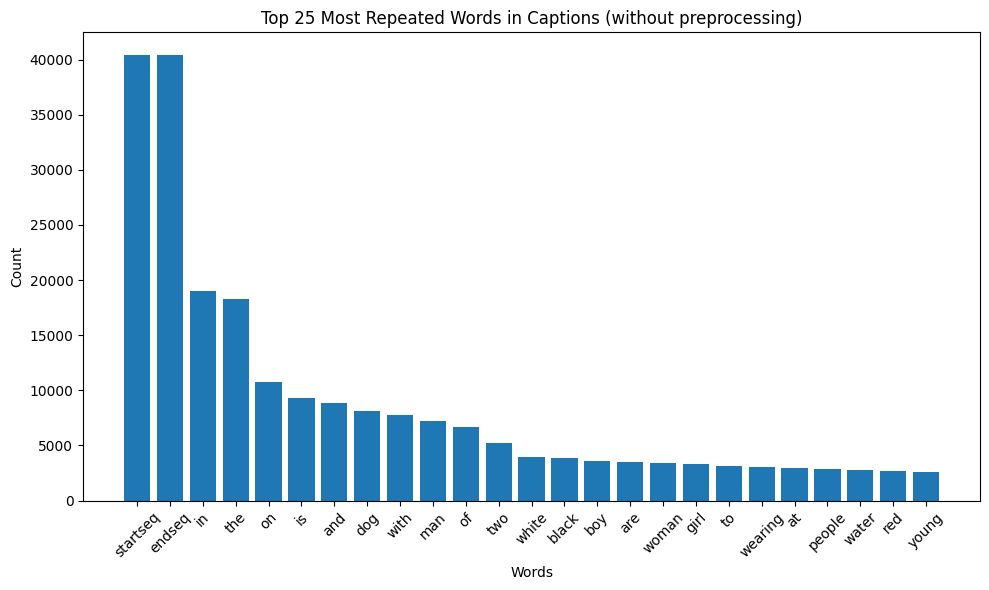

In [140]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract captions from the dictionary
captions = [caption for caption_list in image_caption_mapping.values() for caption in caption_list]

# Concatenate all captions into a single string
all_caption = ' '.join(captions)

# Split the text into individual words
words = all_caption.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get the top 25 most common words and their counts
top_words = word_counts.most_common(25)
top_words = dict(top_words)

# Prepare the data for the graph
word_labels = list(top_words.keys())
word_values = list(top_words.values())

# Create a bar plot of the top 25 most repeated words
plt.figure(figsize=(10, 6))
plt.bar(word_labels, word_values)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 25 Most Repeated Words in Captions (without preprocessing)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Finding maxlen of a caption in the dataset

In [141]:
# Calculate the maximum length of captions
maxlen = max(len(caption.split()) for caption in all_captions)

# Print the maximum length
print(maxlen)

37


### 7. Train the dataset using CNN and LSTM combined model

In [142]:
def data_generator(data_keys, mapping, features, tokenizer, maxlen, vocab_size, batch_size):
    # Initialize empty lists to store input and output data
    X1, X2, y = list(), list(), list()
    n = 0

    # Infinite loop to generate data batches
    while 1:
        # Iterate over the data keys
        for key in data_keys:
            n += 1

            # Skip keys not present in the features dictionary
            if key not in features:
                continue

            captions = mapping[key]

            # Process each caption for the current key
            for caption in captions:
                # Encode the sequence using the tokenizer
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Split the sequence into input (X) and output (y) pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad the input sequence to the maximum length
                    in_seq = pad_sequences([in_seq], maxlen=maxlen)[0]

                    # Encode the output sequence as one-hot vectors
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store the input and output sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            # Check if a batch size has been reached
            if n == batch_size:
                # Convert the lists to numpy arrays
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                # Yield the batch data as output
                yield [X1, X2], np.array(y)

                # Reset the lists and counter for the next batch
                X1, X2, y = list(), list(), list()
                n = 0

In [143]:
size = len(image_caption_mapping.keys())
size*.9

7281.900000000001

- Using 90 % of the data as train data

In [144]:
map = list(image_caption_mapping.keys())
train = [map[i] for i in range(0,7284)]

test = [map[i] for i in range(7284,)]

In [145]:
from tensorflow.keras.layers import dot, Activation, BatchNormalization

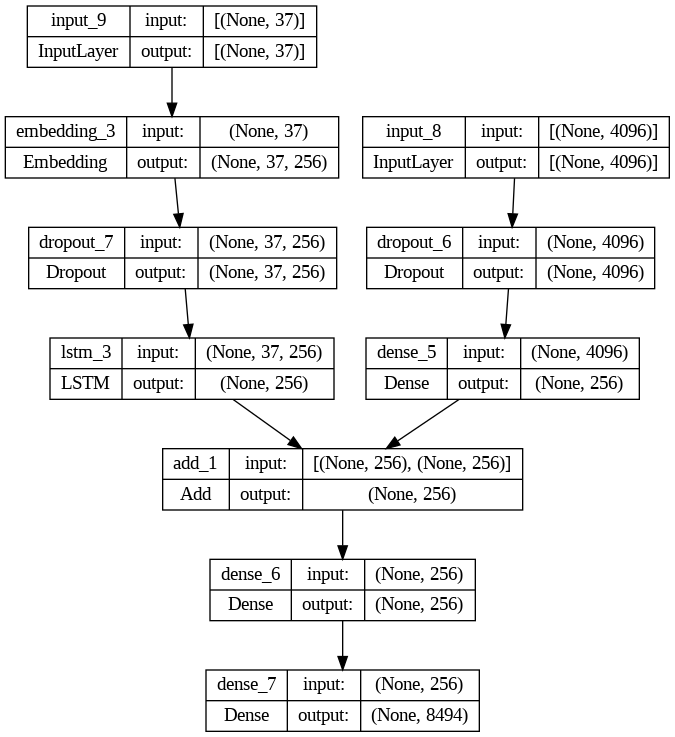

In [149]:
# encoder model
#image feature layers
image_input  = Input(shape=(4096,))
image_features1 = Dropout(0.4)(image_input)
image_features2 = Dense(256, activation='relu')(image_features1)

# Sequence feature extraction model
caption_input = Input(shape=(maxlen,))
caption_model = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_model1 = Dropout(0.4)(caption_model)
caption_model2 = LSTM(256)(caption_model1)

# Decoder model
decoder_input = add([image_features2, caption_model2])
decoder_output = Dense(256, activation='relu')(decoder_input)
decoder_output = Dense(vocab_size, activation='softmax')(decoder_output)

# Combined model
model = Model(inputs=[image_input, caption_input], outputs=decoder_output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot the model
plot_model(model, show_shapes=True)

In [151]:
epochs = 25
batch_size = 32
steps = len(train) // batch_size

# Training loop for specified number of epochs
for epoch in range(epochs):
    # Create data generator for current epoch
    generator = data_generator(train, image_caption_mapping, features, tokenizer, maxlen, vocab_size, batch_size)

    # Fit the model for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 59s 261ms/step - loss: 2.0745


### 8. Saving the model

In [152]:
model.save("model.h5")

### 9. Testing the model

In [153]:
#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
from keras.utils import pad_sequences
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

In [154]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [188]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
          break
    return in_text

In [156]:
# extract features from each photo in the directory
def extract_feature(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

In [229]:
# predict_caption_function
def predict_caption(test):
    tokenizer = load(open('tokenizer.pkl', 'rb'))
    model = load_model('model.h5')
    max_length = 37
    photo = extract_feature(test)
    description = generate_desc(model, tokenizer, photo, max_length)
    d = description.split(" ")
    d = d[1:-1]
    description = " ".join(d)
    description.lower()
    parser = PlaintextParser.from_string(description, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, sentences_count=1)
    description = " ".join(str(sentence) for sentence in summary[0].words[:10])
    return description

In [158]:
maxlen

37

In [159]:
from PIL import Image
import matplotlib.pyplot as plt

def showimg(p):

  image = Image.open(p)

  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [160]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption (picture):
  # predict the caption

  predicted = predict_caption(picture)
  print('Prediction')
  print(predicted)
  showimg(picture)

### 10. Results of the project

Prediction
car is crossing the street near bridge and water car


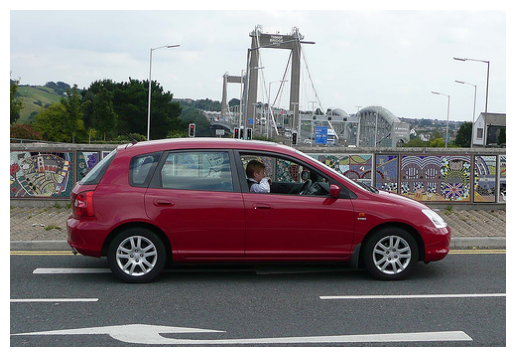

In [230]:
generate_caption(picture = '/content/car.jpg')

Prediction
little blond dog is sitting on the bench with his


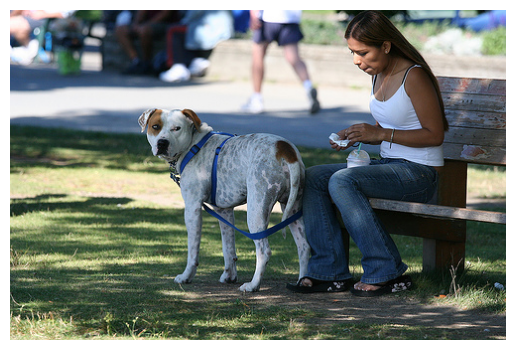

In [214]:
generate_caption(picture = '/content/dogandwomen.jpg')

Prediction
little girl in pink dress is eating ice cream flowers


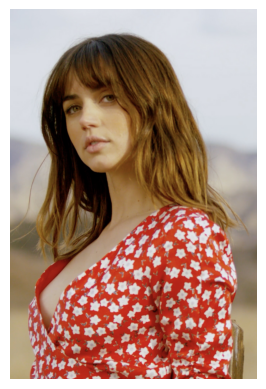

In [215]:
generate_caption(picture = '/content/Ana_de_Armas.jpg')

Prediction
golden dog is running on the grass with its mouth


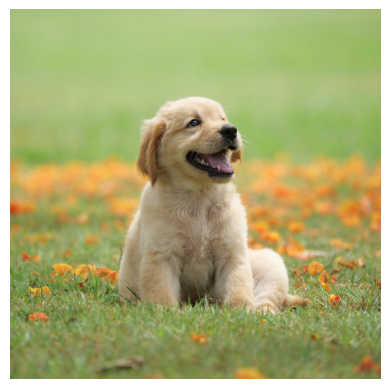

In [231]:
generate_caption(picture = '/content/dog-puppy-on-garden-royalty.jpg')